In [191]:
import netket as nk
import jax.numpy as jnp
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from scipy.sparse.linalg import eigsh
import jax
from netket.operator.spin import sigmax,sigmaz
import jax.flatten_util
import pickle
from typing import Union, Any
import numpy as np
import jax
from jax import numpy as jnp
from flax import linen as nn
from jax.nn.initializers import normal
from netket.utils.types import NNInitFunc
from netket import nn as nknn
default_kernel_init = normal(stddev=0.01)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from tqdm import trange
import time
import json
import glob
from sklearn.decomposition import KernelPCA


In [3]:

def get_psi(vstate,hi,model):
    '''
    Function that returns a vector with the wavefunction probability amplitudes

    Inputs ---
    vsate: Netket's vstate object, the variational quantum state
    hi:    Hilbert space 
    model: Instance of RBM model

    Outputs ---
    psi:   Vector of probability amplitudes indexed all possible by configurations/eigenstates of the Hilbert space

    '''
    parameters = vstate.variables
    all_configurations = hi.all_states()

    logpsi = model.apply(parameters,all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi/ jnp.linalg.norm(psi)

    return psi

In [6]:
# load json into a dictionary
filename_baseconfig = 'configs/config_0.json'
with open (filename_baseconfig, 'r') as f:
    base_config = json.load(f)
base_config

{'system_size': 4,
 'optimizers': 'sgd',
 'learning_rates': 0.001,
 'alpha': 1,
 'training_steps': 50,
 'symmetric': True,
 'dh': 0.025,
 'h_low': 0.0,
 'h_high': 3.0}

In [60]:
def get_all_sweep(fixed, sweep):
    sweep_values = {}
    all_configs = glob.glob(f'../delftblue/configs_N{fixed['system_size']}/*.json')
    for file in all_configs:
        with open (file, 'r') as f:
            config = json.load(f)
        if all(config[key] == fixed[key] for key in fixed.keys()):
            sweep_values[int(file.split('_')[-1].split('.')[0])] = config[sweep]
    # return sorted dictionary
    sweep_values = dict(sorted(sweep_values.items()))
    return sweep_values

def get_color_from_hs(hs):
    color_hs = []
    for i in range(len(hs)//3):
        color_hs.append(plt.cm.RdBu(0.5*(i/(len(hs)//3))))
    for i in range(len(hs) - (len(hs)//3)):
        color_hs.append(plt.cm.RdBu(0.5 + 0.5*(i/(len(hs) - len(hs)//3))))
    return color_hs

In [270]:
H_HIGH = 3.0
H_LOW = 0.0

fixed = {'system_size': 8,
        'optimizers': 'adam',
        'alpha': 1,
        'training_steps': 50,
        #'symmetric': False,
        'learning_rates': 0.01,
        'dh': 0.1}

sweep = 'learning_rates'
sweep = 'symmetric'
#sweep = 'alpha'
#sweep = 'training_steps'

hs = np.arange(H_LOW, H_HIGH+1.e-10, fixed['dh'])
color_hs = get_color_from_hs(hs)
sweep_values = get_all_sweep(fixed, sweep)

In [271]:
energy_error = {'baseline': {}}
infidelity = {'baseline': {}}
weights = {'baseline': {}}
energy_error['finetune'] = {}
infidelity['finetune'] = {}
weights['finetune'] = {}

for index in list(sweep_values.keys()):
    with open(f'../delftblue/results_N{fixed['system_size']}/{index}/baselines/all_results.json', 'r') as f:
        results = json.load(f)
    energy_error['baseline'][sweep_values[index]] = []
    infidelity['baseline'][sweep_values[index]] = []
    weights['baseline'][sweep_values[index]] = []
    for h in hs:
        e_approx = results[f'{h:.3f}']['energy']
        e_exact = results[f'{h:.3f}']['energy_exact']
        energy_error['baseline'][sweep_values[index]].append(np.abs(np.abs(e_approx) - np.abs(e_exact)))
        infid = results[f'{h:.3f}']['infidelity']
        infidelity['baseline'][sweep_values[index]].append(infid)
        weights['baseline'][sweep_values[index]].append(results[f'{h:.3f}']['params'])

    finetunes = glob.glob(f'../delftblue/results_N{fixed["system_size"]}/{index}/finetune/*')
    for finetune_folder in finetunes:
        finetune_value = finetune_folder.split('/')[-1].split('_h')[-1]
        energy_error['finetune'][finetune_value] = {} if energy_error['finetune'].get(finetune_value, 'none') == 'none' else energy_error['finetune'][finetune_value]
        infidelity['finetune'][finetune_value] = {} if infidelity['finetune'].get(finetune_value, 'none') == 'none' else infidelity['finetune'][finetune_value]
        weights['finetune'][finetune_value] = {} if weights['finetune'].get(finetune_value, 'none') == 'none' else weights['finetune'][finetune_value]
        with open(f'{finetune_folder}/all_results.json', 'r') as f:
            results = json.load(f)
        energy_error['finetune'][finetune_value][sweep_values[index]] = []
        infidelity['finetune'][finetune_value][sweep_values[index]] = []
        weights['finetune'][finetune_value][sweep_values[index]] = []

        for h in hs:
            e_approx = results[f'{h:.3f}']['energy']
            e_exact = results[f'{h:.3f}']['energy_exact']
            energy_error['finetune'][finetune_value][sweep_values[index]].append(np.abs(np.abs(e_approx) - np.abs(e_exact)))
            infid = results[f'{h:.3f}']['infidelity']
            infidelity['finetune'][finetune_value][sweep_values[index]].append(infid)
            weights['finetune'][finetune_value][sweep_values[index]].append(results[f'{h:.3f}']['params'])


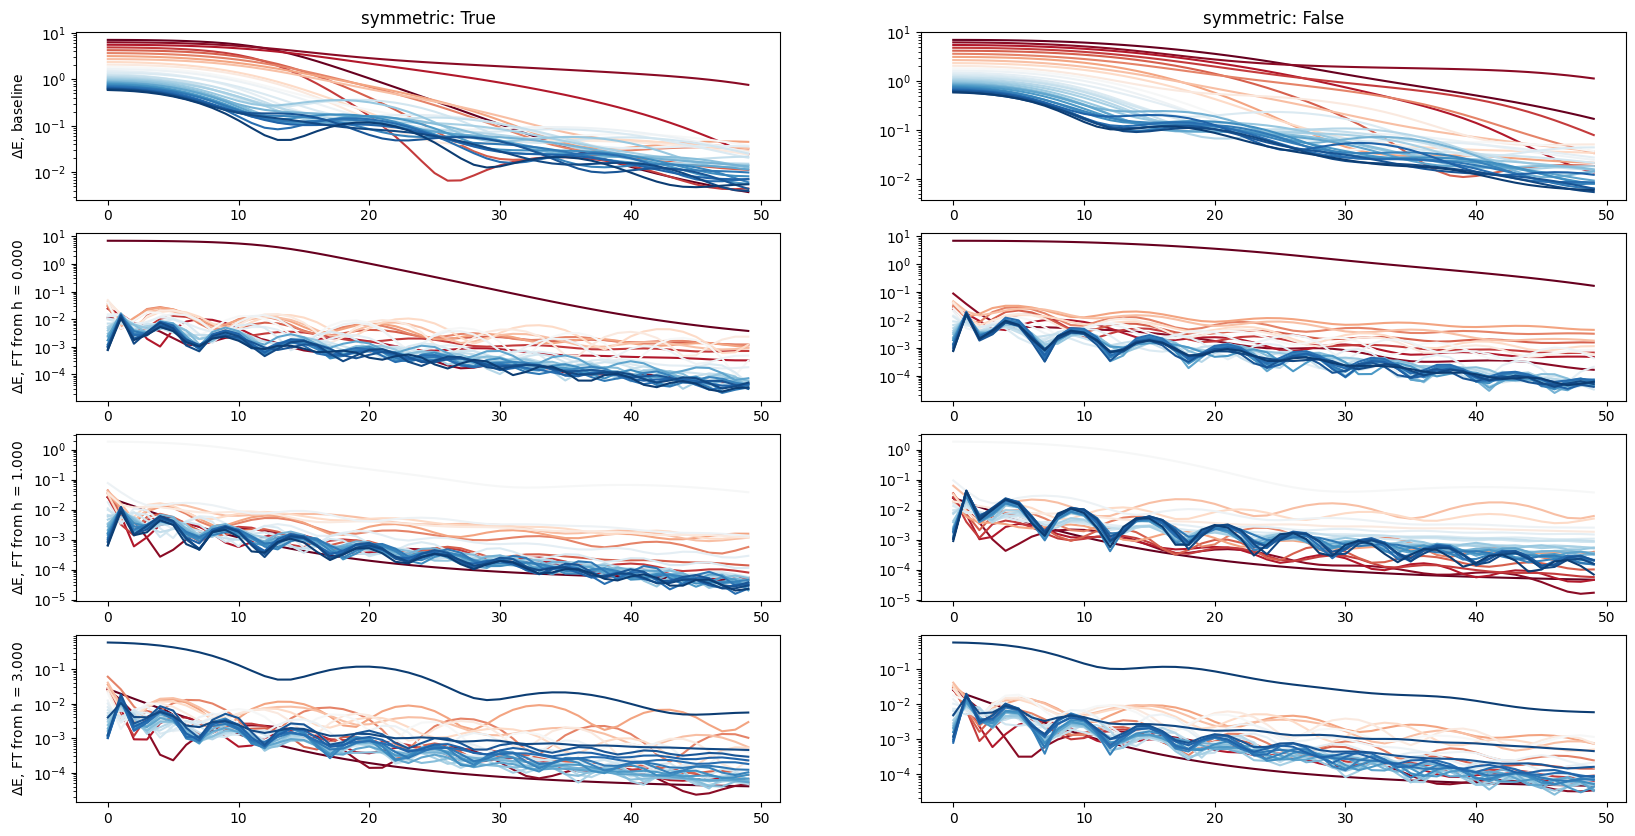

In [272]:
fig, ax = plt.subplots(4, len(list(sweep_values.keys())), figsize = (20, 10))

for i, key in enumerate(list(sweep_values.keys())):
    for j in range(len(energy_error['baseline'][sweep_values[key]])):
        ax[0,i].plot(np.arange(len(energy_error['baseline'][sweep_values[key]][j])), energy_error['baseline'][sweep_values[key]][j], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
    ax[0,i].set_yscale('log')
    ax[0,0].set_ylabel(r'$\Delta$E, baseline')
    ax[0,i].set_title(f'{sweep}: {sweep_values[key]}')

    for k, h_baseline in enumerate(['0.000', '1.000', '3.000']):
        for j in range(len(energy_error['finetune'][h_baseline][sweep_values[key]])):
            ax[k+1,i].plot(np.arange(len(energy_error['baseline'][sweep_values[key]][j])), energy_error['finetune'][h_baseline][sweep_values[key]][j], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
        ax[k+1,i].set_yscale('log')
        ax[k+1,0].set_ylabel(r'$\Delta$E, FT from h = ' + h_baseline)



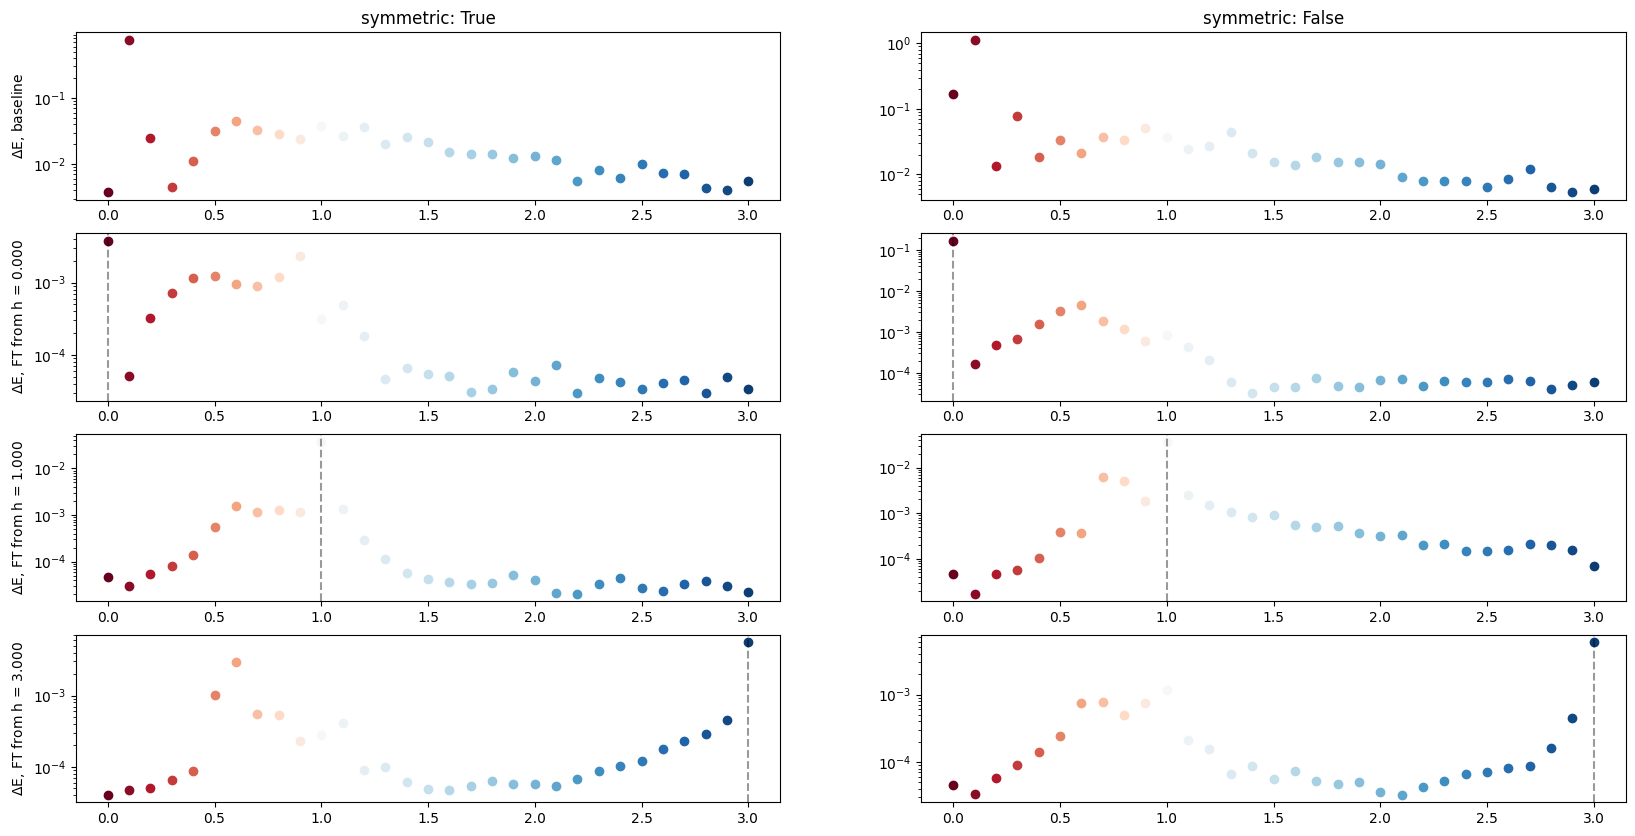

In [273]:
fig, ax = plt.subplots(4, len(list(sweep_values.keys())), figsize = (20, 10))

for i, key in enumerate(list(sweep_values.keys())):
    for j, h in enumerate(hs):
        ax[0,i].scatter(h, energy_error['baseline'][sweep_values[key]][j][-1], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
    ax[0,i].set_yscale('log')
    ax[0,0].set_ylabel(r'$\Delta$E, baseline')
    ax[0,i].set_title(f'{sweep}: {sweep_values[key]}')

    for k, h_baseline in enumerate(['0.000', '1.000', '3.000']):
        for j, h in enumerate(hs):
            ax[k+1,i].scatter(h, energy_error['finetune'][h_baseline][sweep_values[key]][j][-1], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
        ax[k+1,i].set_yscale('log')
        ax[k+1,0].set_ylabel(r'$\Delta$E, FT from h = ' + h_baseline)
        ax[k+1,i].axvline(x=float(h_baseline), color='black', linestyle='--', alpha = 0.4)

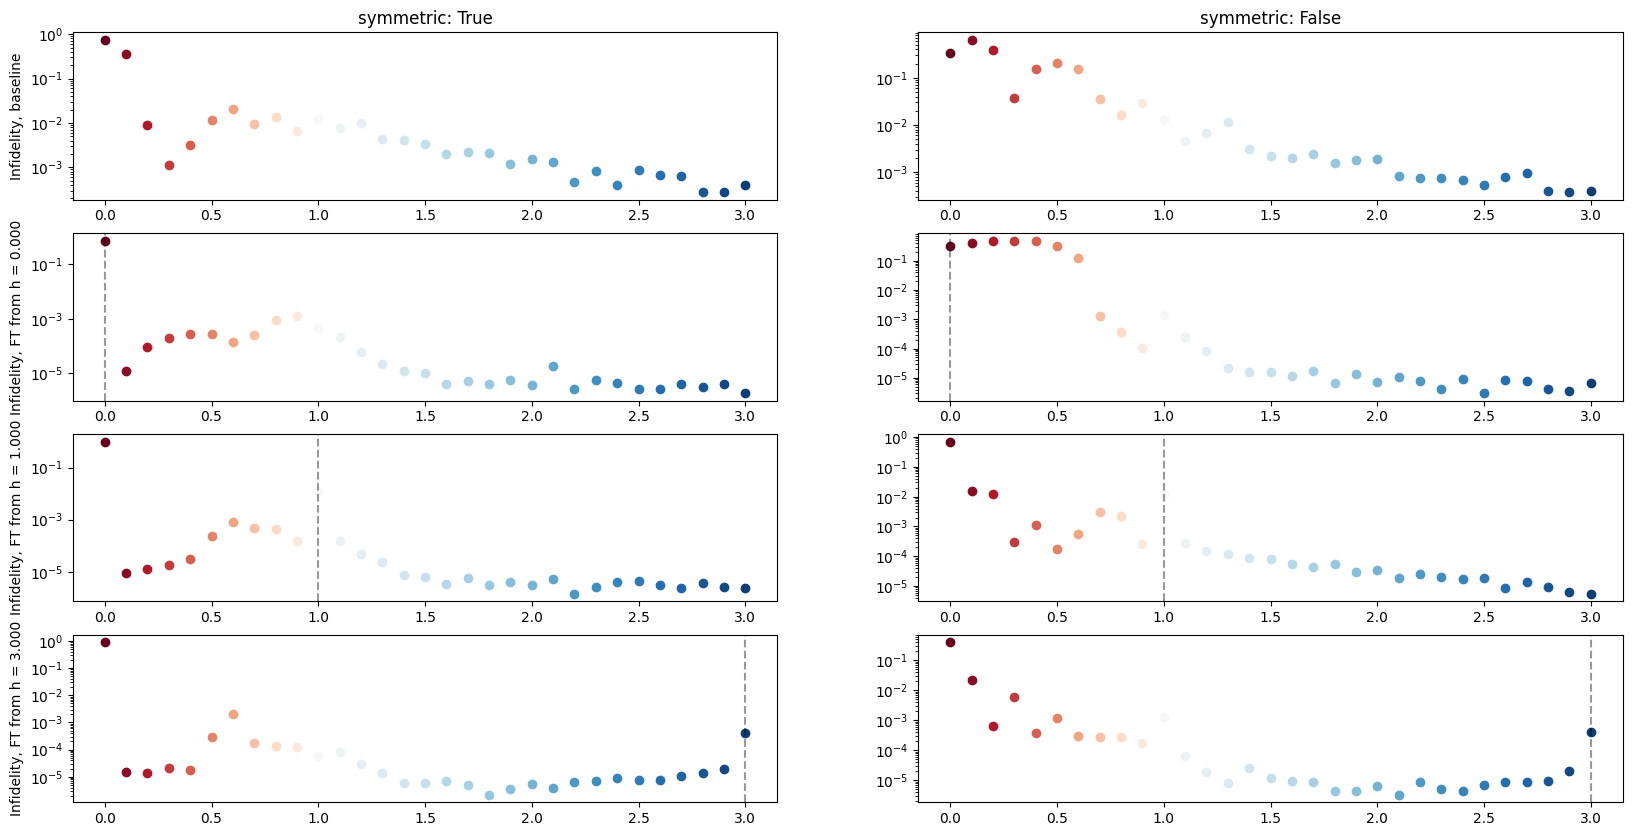

In [274]:
fig, ax = plt.subplots(4, len(list(sweep_values.keys())), figsize = (20, 10))
for i, key in enumerate(list(sweep_values.keys())):
    for j in range(len(infidelity['baseline'][sweep_values[key]])):
        ax[0,i].scatter(hs[j], infidelity['baseline'][sweep_values[key]][j], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
    ax[0,i].set_yscale('log')
    ax[0,0].set_ylabel(r'Infidelity, baseline')
    ax[0,i].set_title(f'{sweep}: {sweep_values[key]}')

    for k, h_baseline in enumerate(['0.000', '1.000', '3.000']):
        for j in range(len(infidelity['finetune'][h_baseline][sweep_values[key]])):
            ax[k+1,i].scatter(hs[j], infidelity['finetune'][h_baseline][sweep_values[key]][j], color=color_hs[j], label=f'{sweep}: {sweep_values[key]}')
        ax[k+1,i].set_yscale('log')
        ax[k+1,0].set_ylabel(r'Infidelity, FT from h = ' + h_baseline)
        ax[k+1,i].axvline(x=float(h_baseline), color='black', linestyle='--', alpha = 0.4)


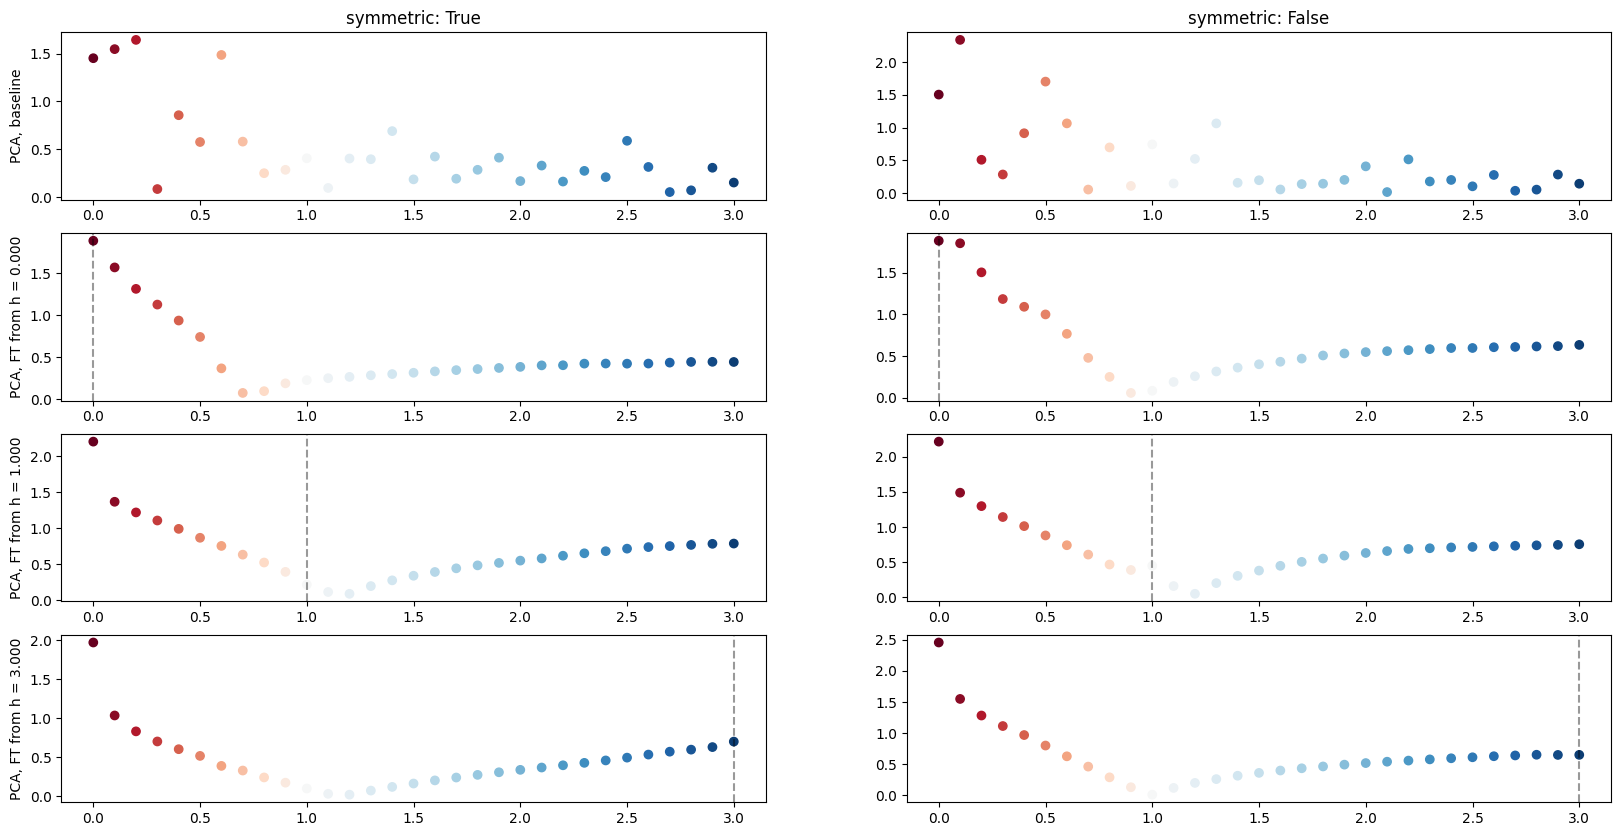

In [275]:
fig, ax = plt.subplots(4, len(list(sweep_values.keys())), figsize = (20, 10))
for i, key in enumerate(list(sweep_values.keys())):
    pca = KernelPCA(n_components = 3, kernel = 'linear')
    X = pca.fit_transform(weights['baseline'][sweep_values[key]])
    ax[0,i].scatter(hs, np.abs(X[:,0]), c=color_hs, label = 'pca1')
    ax[0,0].set_ylabel(r'PCA, baseline')
    ax[0,i].set_title(f'{sweep}: {sweep_values[key]}')

    for k, h_baseline in enumerate(['0.000', '1.000', '3.000']):
        pca = KernelPCA(n_components = 3, kernel = 'linear')
        X = pca.fit_transform(weights['finetune'][h_baseline][sweep_values[key]])
        ax[k+1,i].scatter(hs, np.abs(X[:,0]), color=color_hs)
        ax[k+1,0].set_ylabel(r'PCA, FT from h = ' + h_baseline)
        ax[k+1,i].axvline(x=float(h_baseline), color='black', linestyle='--', alpha = 0.4)

In [ ]:
## plot for all cases, distance from phase transition as a function of the average infidelity/energy error